# SID - 490411065

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import chain, combinations
import warnings

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge

from sklearn.model_selection import GridSearchCV, cross_val_score, KFold

In [2]:
# Other set-up
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = (16,8)
plt.rcParams.update({'font.size': 16})

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore")

five_fold_shuffle = KFold(5, shuffle=True, random_state=1)

train = pd.read_csv('NBA_Train.csv', index_col='Train_ID')

# TASK A CODE - Moneyball

# 2 Exploratory Data Analysis

## 2.2 Data Processing

In [3]:
train.describe(include='all').iloc[:1, :10].applymap(lambda x: str(x).replace('.0', ''))

,SALARY,POSITION,TEAM,Age,Games,Minutes,PER,TS,ORB,DRB
count,126,126,126,126,126,126,126,126,126,126


In [4]:
train.describe(include='all').iloc[:1, 10:].applymap(lambda x: str(x).replace('.0', ''))

,TRB,AST,STL,BLK,TOV,USG,ORtg,DRtg,OWS,DWS,WS
count,126,126,126,126,126,126,126,126,126,126,126


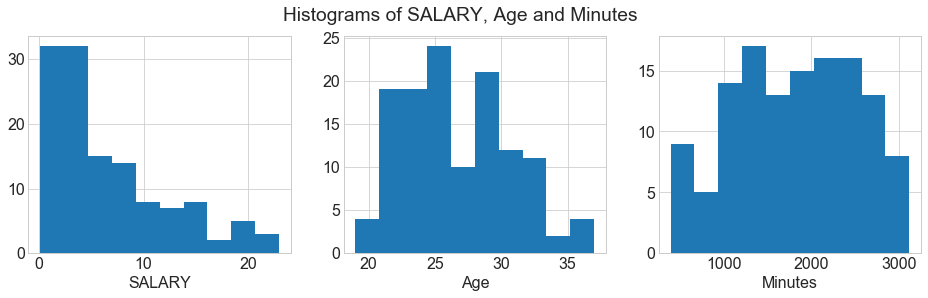

In [5]:
want = ['SALARY', 'Age', 'Minutes']
fig, ax = plt.subplots(1, 3, figsize=(16,4))

for i in range(3):
    curr_var = train[want[i]]
    ax[i].hist(curr_var)
    ax[i].set_xlabel(curr_var.name)

fig.suptitle('Histograms of SALARY, Age and Minutes')
fig.show()

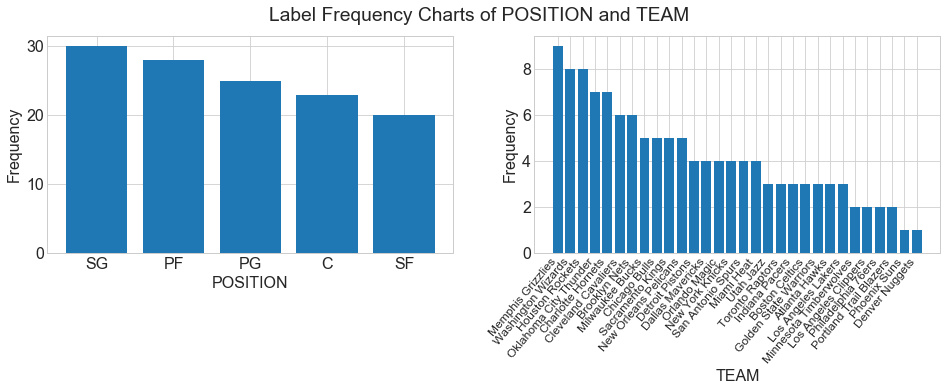

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(16,4))

ax[0].bar(train['POSITION'].value_counts().keys(), train['POSITION'].value_counts())
ax[0].set_xlabel('POSITION')
ax[0].set_ylabel('Frequency')

ax[1].bar(train['TEAM'].value_counts().keys(), train['TEAM'].value_counts())
ax[1].set_xlabel('TEAM')
ax[1].set_ylabel('Frequency')
for tick in ax[1].get_xticklabels():
    tick.set_rotation(50)
    tick.set_horizontalalignment('right')
    tick.set_fontsize(12)
    
fig.suptitle('Label Frequency Charts of POSITION and TEAM')
fig.show()

## 2.3 Simple Analysis

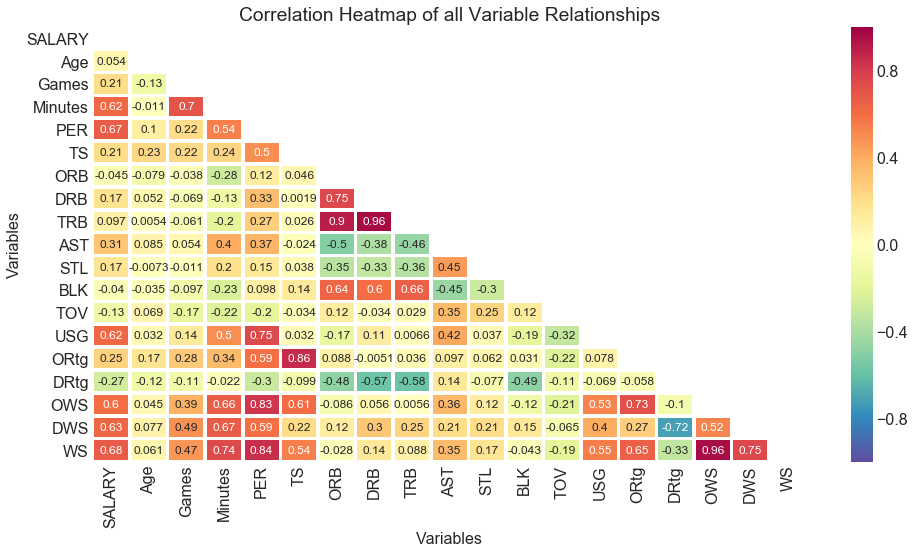

In [7]:
correlations = train.corr()
mask = np.zeros_like(correlations)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(16,8))
sns.heatmap(correlations, cmap='Spectral_r', vmin=-1, vmax=1, mask=mask, linewidths=2.5, annot=True, annot_kws={'fontsize':12})
plt.xlabel('Variables')
plt.ylabel('Variables')
plt.title('Correlation Heatmap of all Variable Relationships')
plt.show()

In [8]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def compute_vif(X):
    X_const = X.copy()
    X_const['Intercept'] = 1
    
    vif = pd.DataFrame()
    vif['Predictors'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X_const.values, i) for i in range(X.shape[1])]
    
    return vif

compute_vif(train.drop(['SALARY', 'POSITION', 'TEAM', 'WS', 'TRB', 'PER', 'ORtg', 'DWS', ], axis=1))

,Predictors,VIF
0,Age,1.307924
1,Games,2.830901
2,Minutes,4.601011
3,TS,2.879257
4,ORB,3.561353
5,DRB,3.741602
6,AST,4.179187
7,STL,1.680080
8,BLK,2.382008
9,TOV,2.501908


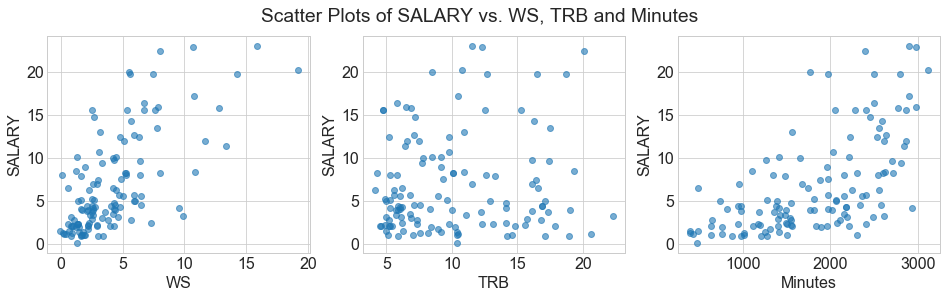

In [9]:
want = ['WS', 'TRB', 'Minutes']
fig, ax = plt.subplots(1, 3, figsize=(16,4))

for i in range(3):
    curr_var = train[want[i]]
    ax[i].scatter(curr_var, train['SALARY'], alpha=0.6)
    ax[i].set_xlabel(curr_var.name)
    ax[i].set_ylabel('SALARY')

fig.suptitle('Scatter Plots of SALARY vs. WS, TRB and Minutes')
fig.show()

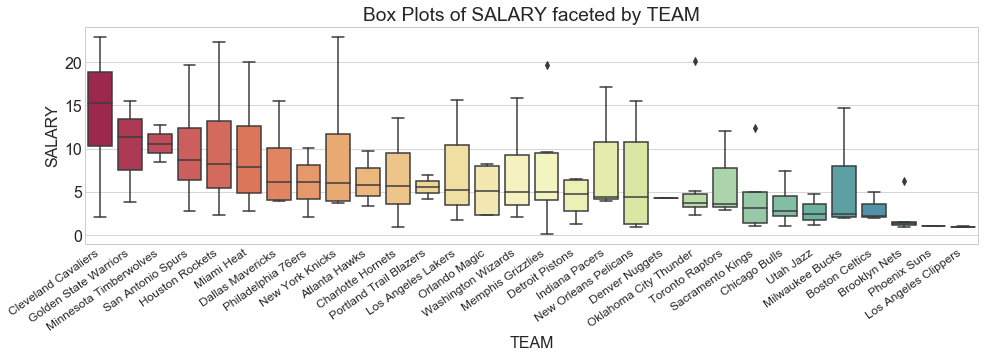

In [10]:
order = train[['SALARY', 'TEAM']].groupby('TEAM').median().sort_values('SALARY', ascending=False).index

plt.figure(figsize=(16,4))
sns.boxplot(x='TEAM', y='SALARY', data=train, order=order, palette='Spectral')
plt.xticks(rotation='35', horizontalalignment='right', fontsize=12)
plt.title('Box Plots of SALARY faceted by TEAM')
plt.show()

# 3 Methodology and Modelling

## 3.1 Preliminary Feature Engineering

In [11]:
def prelim_FE(X):
    X = X.copy()
    
    X = pd.get_dummies(X)
    X = X.drop(['POSITION_C', 'TEAM_Atlanta Hawks'], axis=1)
    
    return X

## 3.2 k-Nearest Neighbours

### 3.2.1 Additional Feature Engineering

In [12]:
def complete_FE(X):
    X = X.copy()
    X = prelim_FE(X)
    
    X = (X - X.mean()) / X.std()
    X = X[['Minutes', 'PER', 'USG', 'DWS', 'WS']]
    
    return X

In [13]:
X_train = complete_FE(train.iloc[:, 1:])
y_train = train['SALARY']

### 3.2.2 Model Selection

In [14]:
def powerset(variables):
    return chain.from_iterable(combinations(variables, r) for r in range(1, len(variables)+1))

In [15]:
results = {}

# Look for the best variable combination AND k-value using CV
for var_combo in powerset(X_train.columns):
    
    gscv = GridSearchCV(
        estimator=KNeighborsRegressor(), 
        param_grid={'n_neighbors': np.arange(1, 101)}, 
        scoring='neg_mean_squared_error', 
        cv=five_fold_shuffle
    )
    gscv.fit(X_train[list(var_combo)], y_train)
    
    lowest_RMSE = np.sqrt(min(-gscv.cv_results_['mean_test_score']))
    results[var_combo] = {
        'model': gscv.best_estimator_, 
        'CV_RMSE': lowest_RMSE
    }
    
# CV results
best_vars = min(results, key=lambda var_combo: results[var_combo]['CV_RMSE'])
results[best_vars]

{'model': KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=11, p=2,
                     weights='uniform'), 'CV_RMSE': 3.616132533803488}

### (part of 4.2) Model Evaluation

In [16]:
test = pd.read_csv('NBA_Test.csv', index_col='Test_ID')
X_test = complete_FE(test.iloc[:, 1:])
y_test = test['SALARY']

# Test set results
model = results[best_vars]['model'].fit(X_train[list(best_vars)], y_train)
y_pred = model.predict(X_test[list(best_vars)])
RMSE = np.sqrt(np.mean((y_test - y_pred)**2))
RMSE

4.064534360235968

## 3.3 Linear Regression

### 3.3.1 Additional Feature Engineering

In [17]:
def complete_FE(X):
    X = X.copy()
    X = prelim_FE(X)
    
    X = X[['Age', 'Games', 'Minutes', 'TS', 'ORB', 'DRB', 'AST', 'STL', 'BLK', 'TOV', 'USG', 'DRtg', 'OWS']]
    
    return X

In [18]:
X_train = complete_FE(train.iloc[:, 1:])
y_train = train['SALARY']

### 3.3.2 Model Selection


In [19]:
p = len(X_train.columns)
selected_vars = []
remaining_vars = list(X_train.columns)
results = {}

# Forward selection algorithm
for k in range(p):
    train_RMSEs = {}
    
    for current_var in remaining_vars:
        model = LinearRegression()
        model.fit(X_train[selected_vars + [current_var]], y_train)
        
        y_pred = model.predict(X_train[selected_vars + [current_var]])
        train_RMSEs[current_var] = np.sqrt(np.mean((y_train - y_pred)**2))
    
    best_var = min(train_RMSEs, key=lambda var: train_RMSEs[var])
    selected_vars.append(best_var)
    remaining_vars.remove(best_var)
    results[tuple(selected_vars)] = {'train_RMSE': train_RMSEs[best_var]}

In [20]:
# Find optimal model complexity using CV
for var_combo in results:
    cv_scores = cross_val_score(
        estimator=LinearRegression(),
        X=X_train[list(var_combo)],
        y=y_train,
        scoring='neg_mean_squared_error', 
        cv=five_fold_shuffle  
    )
    results[var_combo]['CV_RMSE'] = np.sqrt(np.mean(-cv_scores))
    
# Training set and CV results
best_vars = min(results, key=lambda var_combo: results[var_combo]['CV_RMSE'])
results[best_vars]

{'train_RMSE': 3.417486783900387, 'CV_RMSE': 3.5792117846115645}

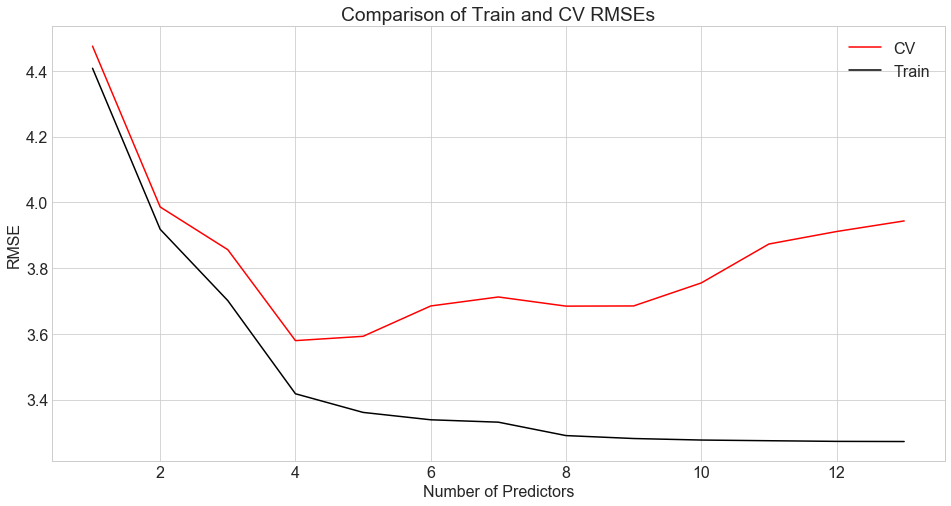

In [21]:
plt.figure()
plt.plot(np.arange(1, 14), [results[var_combo]['CV_RMSE'] for var_combo in results], c='red', label='CV')
plt.plot(np.arange(1, 14), [results[var_combo]['train_RMSE'] for var_combo in results], c='black', label='Train')
plt.xlabel('Number of Predictors')
plt.ylabel('RMSE')
plt.title('Comparison of Train and CV RMSEs')
plt.legend()
plt.show()

### (part of 4.2) Model Evaluation

In [22]:
test = pd.read_csv('NBA_Test.csv', index_col='Test_ID')
X_test = complete_FE(test.iloc[:, 1:])
y_test = test['SALARY']

# Test set results
model = LinearRegression().fit(X_train[list(best_vars)], y_train)
y_pred = model.predict(X_test[list(best_vars)])
RMSE = np.sqrt(np.mean((y_test - y_pred)**2))
RMSE

4.1001456318476786

## 3.4 Lasso

### 3.4.2 Additional Feature Engineering

In [23]:
def complete_FE(X):
    X = X.copy()
    X = prelim_FE(X)
    
    X = (X - X.mean()) / X.std()
    
    return X

In [24]:
X_train = complete_FE(train.iloc[:, 1:])
y_train = train['SALARY']

### 3.4.3 Model Selection

In [26]:
# Find optimal level of regularisation using CV
gscv = GridSearchCV(
    estimator=Lasso(), 
    param_grid={'alpha': np.arange(1, 20)/10}, 
    scoring='neg_mean_squared_error', 
    cv=five_fold_shuffle
)
gscv.fit(X_train, y_train)

lowest_RMSE = np.sqrt(min(-gscv.cv_results_['mean_test_score']))
results = {
    'model': gscv.best_estimator_,
    'CV_RMSE': lowest_RMSE
}

# CV results
results

{'model': Lasso(alpha=0.3, copy_X=True, fit_intercept=True, max_iter=1000,
       normalize=False, positive=False, precompute=False, random_state=None,
       selection='cyclic', tol=0.0001, warm_start=False),
 'CV_RMSE': 3.824295246142231}

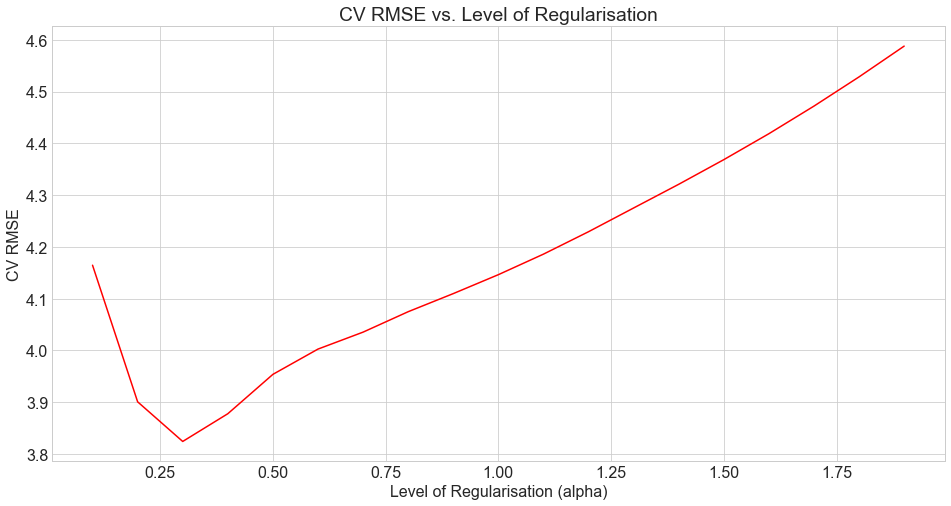

In [27]:
plt.figure()
plt.plot(np.arange(1, 20)/10, np.sqrt(-gscv.cv_results_['mean_test_score']), c='red')
plt.xlabel('Level of Regularisation (alpha)')
plt.ylabel('CV RMSE')
plt.title('CV RMSE vs. Level of Regularisation')
plt.show()

### (part of 4.2) Model Evaluation

In [28]:
test = pd.read_csv('NBA_Test.csv', index_col='Test_ID')
X_test = complete_FE(test.iloc[:, 1:])
X_test['TEAM_Houston Rockets'] = 0
y_test = test['SALARY']

# Test set results
y_pred = results['model'].fit(X_train, y_train).predict(X_test)
RMSE = np.sqrt(np.mean((y_test - y_pred)**2))
RMSE

4.065861388332993